# AE Structural Optimization Final Project: topology optimization
## Author: Donglai Yang

In [62]:
import numpy as np
from scipy import sparse
from scipy import spatial
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.optimize import minimize
import matplotlib.pylab as plt
import matplotlib.tri as tri

class MMA:
    def __init__(self, n, m, x_init, lb, ub, objfunc, gradfunc):
        """
        Method of moving asymptotes (MMA) optimizer

        Parameters:
            n: number of design variables
            m: number of constraints
            x_init: initial design variable values
            lb: lower bounds on design variables
            ub: upper bounds on design variables
            objfunc: function that computes the objective and constraint values
            gradfunc: function that computes the objective and constraint gradients
        """

        self.n = n
        self.m = m

        self.lb = lb
        self.ub = ub
        self.objfunc = objfunc
        self.gradfunc = gradfunc

        self.mma_iter = 0

        # Allocate space for the design variables
        self.x = np.zeros(self.n)
        self.x1 = np.zeros(self.n)
        self.x2 = np.zeros(self.n)

        # Set the initial design point
        self.x[:] = x_init[:]

        # The objective and constraint functions
        self.c = np.zeros(self.m)
        self.g = np.zeros(self.n)
        self.A = np.zeros((self.m, self.n))

        self.b = np.zeros(self.m)
        self.L = np.zeros(self.n)
        self.U = np.zeros(self.n)
        self.alpha = np.zeros(self.n)
        self.beta = np.zeros(self.n)

        self.p = np.zeros((self.m + 1, self.n))
        self.q = np.zeros((self.m + 1, self.n))

        # Set the optimization parameters
        self.move_limit = 0.5
        self.init_asymptote_offset = 0.1
        self.asymptote_relax = 1.2
        self.asymptote_contract = 0.7
        self.min_asymptote_offset = 1e-3
        self.max_asymptote_offset = 10.0
        self.eps_regularization = 0.0  # 1e-5
        self.delta_regularization = 0.0  # 1e-3

    def update_asymptotes(self):
        lower = np.maximum(self.lb, self.x - self.move_limit)
        upper = np.minimum(self.ub, self.x + self.move_limit)
        diff = upper - lower

        if self.mma_iter < 2:
            self.L = self.x - self.init_asymptote_offset * diff
            self.U = self.x + self.init_asymptote_offset * diff
        else:
            # Compute the product of the difference of the two previous
            # updates to determine how to update the move limits. If the
            # signs are different, then indc < 0.0 and we contract the
            # asymptotes, otherwise we expand the asymptotes.
            indc = (self.x - self.x1) * (self.x1 - self.x2)

            # Compute the interval length
            intrvl = np.maximum(diff, 0.01)
            intrvl = np.minimum(intrvl, 100.0)

            # Select contraction or relaxation factors per index
            mask = indc < 0.0
            scale = np.where(mask, self.asymptote_contract, self.asymptote_relax)

            # Update the asymtotes
            self.L = self.x - scale * (self.x1 - self.L)
            self.U = self.x + scale * (self.U - self.x1)

            # Ensure that the asymptotes do not converge entirely on the design
            # variable value
            self.L = np.minimum(self.L, self.x - self.min_asymptote_offset * intrvl)
            self.U = np.maximum(self.U, self.x + self.min_asymptote_offset * intrvl)

            # Enforce a maximum offset so that the asymptotes do not move too far
            # away from the design variables
            self.L = np.maximum(self.L, self.x - self.max_asymptote_offset * intrvl)
            self.U = np.minimum(self.U, self.x + self.max_asymptote_offset * intrvl)

        # Compute the differences
        Ux = self.U - self.x
        xL = self.x - self.L

        # Compute the lower and upper bounds
        self.alpha = np.maximum(lower, 0.9 * self.L + 0.1 * self.x, self.x - 0.5 * diff)
        self.beta = np.minimum(upper, 0.9 * self.U + 0.1 * self.x, self.x + 0.5 * diff)

        # Compute the MMA coefficients for the objective
        eps = self.eps_regularization
        delta = self.delta_regularization
        gpos = np.maximum(self.g, 0.0)
        gneg = np.maximum(-self.g, 0.0)
        gpos_reg = (1.0 + delta) * gpos + delta * gneg + eps / (self.U - self.L)
        gneg_reg = (1.0 + delta) * gneg + delta * gpos + eps / (self.U - self.L)

        # Update p and q for the objective
        self.p[0, :] = gpos_reg * Ux**2
        self.q[0, :] = gneg_reg * xL**2

        # Update p and q for the constraints
        gpos = np.maximum(self.A, 0.0)
        gneg = np.maximum(-self.A, 0.0)
        self.p[1:, :] = gpos * Ux**2
        self.q[1:, :] = gneg * xL**2

        # Compute the b right-hand-side for the constraints
        self.b[:] = -self.c
        self.b[:] += np.sum(self.p[1:, :] / Ux, axis=1)
        self.b[:] += np.sum(self.q[1:, :] / xL, axis=1)

        return

    def compute_design_from_dual(self, y):
        """Compute the design variables from the dual variables"""

        # Convenience variable y0 = [1.0, y[0], y[1], ..., y[m-1]]
        y0 = np.ones(self.m + 1)
        y0[1:] = y[:]

        # Compute the design variables as a function of the dual variables x(y)
        a = np.sqrt(self.p.T @ y0)
        b = np.sqrt(self.q.T @ y0)

        return np.clip((a * self.L + b * self.U) / (a + b), self.alpha, self.beta)

    def dual_objective(self, y):
        x0 = self.compute_design_from_dual(y)

        y0 = np.ones(self.m + 1)
        y0[1:] = y[:]

        # Compute the dual objective function
        Ux = self.U - x0
        xL = x0 - self.L
        obj = np.sum((self.p.T @ y0) / Ux + (self.q.T @ y0) / xL) - np.dot(y, self.b)

        # Return the negative of the dual objective since we want
        # to maximize the objective function
        return -1.0 * obj

    def dual_gradient(self, y):
        x0 = self.compute_design_from_dual(y)

        # Initialize the gradient
        g = np.zeros(self.m)
        g[:] = -self.b

        Ux = self.U - x0
        xL = x0 - self.L
        g[:] += np.sum(self.p[1:, :] / Ux[np.newaxis, :], axis=1)
        g[:] += np.sum(self.q[1:, :] / xL[np.newaxis, :], axis=1)

        return -g

    def solve_dual_problem(self):

        # Define the initial point
        y_init = np.ones(self.m)

        # Define bounds: x >= 0
        bounds = [(0, None)] * self.m

        # Run optimization
        res = minimize(
            self.dual_objective,
            y_init,
            bounds=bounds,
            method="L-BFGS-B",
        )

        if not res.success:
            print("MMA subproblem optimization failed")
            return np.zeros(self.m)

        return res.x

    def update(self):
        fobj, con = self.objfunc(self.x) 
        # print("self.c shape:", self.c.shape, " con shape:", np.array(con).shape)
        self.c[:] = con[:] # constraint values

        grad, jac = self.gradfunc(self.x)
        # print("self.g shape:", self.g.shape, " grad shape:", grad.shape)
        # print("self.A shape:", self.A.shape, " jac shape:", jac.shape)
        self.g[:] = grad[:] # gradient of objective
        self.A[:] = jac # gradient of constraints

        # Update the asymptotes
        self.update_asymptotes()

        # Solve the dual subproblem
        y = self.solve_dual_problem()

        # Update the design variables
        self.x2[:] = self.x1[:]
        self.x1[:] = self.x[:]
        self.x[:] = self.compute_design_from_dual(y)

        self.mma_iter += 1

        return

In [ ]:
from matplotlib import contour


def eval_shape_funcs(eta, xi):
    """
    Evaluate the shape functions and their derivatives
    """

    N = 0.25 * np.array(
        [
            (1.0 - xi) * (1.0 - eta),
            (1.0 + xi) * (1.0 - eta),
            (1.0 + xi) * (1.0 + eta),
            (1.0 - xi) * (1.0 + eta),
        ]
    )
    Nxi = 0.25 * np.array([-(1.0 - eta), (1.0 - eta), (1.0 + eta), -(1.0 + eta)])
    Neta = 0.25 * np.array([-(1.0 - xi), -(1.0 + xi), (1.0 + xi), (1.0 - xi)])

    return N, Nxi, Neta


def eval_shape_funcs_gradient(xi, eta, xe, ye):
    """
    Evaluate the derivative of the shape functions in the physical
    coordinate system by applying the Jacobian transformation
    """

    N, Nxi, Neta = eval_shape_funcs(eta, xi)

    # Store the Jacobian and the inverse of the Jacobian
    nelems = xe.shape[0]
    J = np.zeros((nelems, 2, 2))
    invJ = np.zeros(J.shape)

    # Compute the Jacobian transformation at each quadrature points
    J[:, 0, 0] = np.dot(xe, Nxi)
    J[:, 1, 0] = np.dot(ye, Nxi)
    J[:, 0, 1] = np.dot(xe, Neta)
    J[:, 1, 1] = np.dot(ye, Neta)

    # Compute the inverse of the Jacobian
    detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
    invJ[:, 0, 0] = J[:, 1, 1] / detJ
    invJ[:, 0, 1] = -J[:, 0, 1] / detJ
    invJ[:, 1, 0] = -J[:, 1, 0] / detJ
    invJ[:, 1, 1] = J[:, 0, 0] / detJ

    # Compute the derivative of the shape functions w.r.t. xi and eta
    # [Nx, Ny] = [Nxi, Neta]*invJ
    Nx = np.outer(invJ[:, 0, 0], Nxi) + np.outer(invJ[:, 1, 0], Neta)
    Ny = np.outer(invJ[:, 0, 1], Nxi) + np.outer(invJ[:, 1, 1], Neta)

    return detJ, Nx, Ny


class NodeFilter:
    """
    A node-based filter for topology optimization
    """

    def __init__(
        self, conn, X, r0=1.0, ftype="spatial", beta=10.0, eta=0.5, projection=False
    ):
        """
        Create a filter
        """
        self.conn = np.array(conn)
        self.X = np.array(X)
        self.nelems = self.conn.shape[0]
        self.nnodes = int(np.max(self.conn)) + 1

        # Store information about the projection
        self.beta = beta
        self.eta = eta
        self.projection = projection

        # Store information about the filter
        self.F = None
        self.A = None
        self.B = None
        if ftype == "spatial":
            self._initialize_spatial(r0)
        else:
            self._initialize_helmholtz(r0)

        return

    def _initialize_spatial(self, r0):
        """
        Initialize the spatial filter
        """

        # Create a KD tree
        tree = spatial.KDTree(self.X)

        F = sparse.lil_matrix((self.nnodes, self.nnodes))
        for i in range(self.nnodes):
            indices = tree.query_ball_point(self.X[i, :], r0)
            Fhat = np.zeros(len(indices))

            for j, index in enumerate(indices):
                dist = np.sqrt(
                    np.dot(
                        self.X[i, :] - self.X[index, :], self.X[i, :] - self.X[index, :]
                    )
                )
                Fhat[j] = r0 - dist

            Fhat = Fhat / np.sum(Fhat)
            F[i, indices] = Fhat

        self.F = F.tocsr()
        self.FT = self.F.transpose()

        return

    def _initialize_helmholtz(self, r0):
        i = []
        j = []
        for index in range(self.nelems):
            for ii in self.conn[index, :]:
                for jj in self.conn[index, :]:
                    i.append(ii)
                    j.append(jj)

        # Convert the lists into numpy arrays
        i_index = np.array(i, dtype=int)
        j_index = np.array(j, dtype=int)

        # Quadrature points
        gauss_pts = [-1.0 / np.sqrt(3.0), 1.0 / np.sqrt(3.0)]

        # Assemble all of the the 4 x 4 element stiffness matrices
        Ae = np.zeros((self.nelems, 4, 4))
        Ce = np.zeros((self.nelems, 4, 4))

        Be = np.zeros((self.nelems, 2, 4))
        He = np.zeros((self.nelems, 1, 4))

        # Compute the x and y coordinates of each element
        xe = self.X[self.conn, 0]
        ye = self.X[self.conn, 1]

        for j in range(2):
            for i in range(2):
                xi = gauss_pts[i]
                eta = gauss_pts[j]
                # Evaluate the gradient of the shape functions in physical coordinates
                N, Nxi, Neta = eval_shape_funcs(xi, eta)
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, xe, ye)

                # Set the B matrix for each element
                He[:, 0, :] = N
                Be[:, 0, :] = Nx
                Be[:, 1, :] = Ny

                Ce += np.einsum("n,nij,nil -> njl", detJ, He, He)
                Ae += np.einsum("n,nij,nil -> njl", detJ * r0**2, Be, Be)

        # Finish the computation of the Ae matrices
        Ae += Ce

        A = sparse.coo_matrix((Ae.flatten(), (i_index, j_index)))
        A = A.tocsc()
        self.A = linalg.factorized(A)

        B = sparse.coo_matrix((Ce.flatten(), (i_index, j_index)))
        self.B = B.tocsr()
        self.BT = self.B.transpose()

        return

    def apply_filter(self, x):
        if self.F is not None:
            rho = self.F @ x
        else:
            rho = self.A(self.B.dot(x))

        if self.projection:
            denom = np.tanh(self.beta * self.eta) + np.tanh(
                self.beta * (1.0 - self.eta)
            )
            rho = (
                np.tanh(self.beta * self.eta) + np.tanh(self.beta * (rho - self.eta))
            ) / denom

        return rho

    def apply_filter_gradient(self, g, x=None):
        if self.projection:
            if self.F is not None:
                rho = self.F @ x
            else:
                rho = self.A(self.B.dot(x))

            denom = np.tanh(self.beta * self.eta) + np.tanh(
                self.beta * (1.0 - self.eta)
            )
            grad = (
                (self.beta / denom) * 1.0 / np.cosh(self.beta * (rho - self.eta)) ** 2
            ) * g
        else:
            grad = g

        if self.F is not None:
            return self.FT @ grad
        else:
            return self.BT.dot(self.A(grad))

    def plot(self, u, ax=None, colorbar=True, **kwargs):
        """
        Create a plot
        """

        # Create the triangles
        triangles = np.zeros((2 * self.nelems, 3), dtype=int)
        triangles[: self.nelems, 0] = self.conn[:, 0]
        triangles[: self.nelems, 1] = self.conn[:, 1]
        triangles[: self.nelems, 2] = self.conn[:, 2]

        triangles[self.nelems :, 0] = self.conn[:, 0]
        triangles[self.nelems :, 1] = self.conn[:, 2]
        triangles[self.nelems :, 2] = self.conn[:, 3]

        # Create the triangulation object
        tri_obj = tri.Triangulation(self.X[:, 0], self.X[:, 1], triangles)

        if ax is None:
            fig, ax = plt.subplots()

        # Set the aspect ratio equal
        ax.set_aspect("equal")

        # Create the contour plot
        contour = ax.tricontourf(tri_obj, u, **kwargs)

        if colorbar:
            plt.colorbar(contour, ax=ax)
            # add colorbar limit
            contour.set_clim(0, 1)

        return


class PlaneStress:
    def __init__(
        self, conn, X, bcs, forces={}, E=10.0, nu=0.3, rho=1.0, p=3.0, fltr=None
    ):
        self.conn = np.array(conn)
        self.X = np.array(X)

        self.nelems = self.conn.shape[0]
        self.nnodes = int(np.max(self.conn)) + 1
        self.nvars = 2 * self.nnodes

        # Compute the constitutive matrix
        self.C = E * np.array(
            [[1.0, nu, 0.0], [nu, 1.0, 0.0], [0.0, 0.0, 0.5 * (1.0 - nu)]]
        )
        self.C *= 1.0 / (1.0 - nu**2) 
        self.rho = rho # material density
        self.p = p # exponent in SIMP

        # Set the filter
        self.fltr = fltr

        self.reduced = self._compute_reduced_variables(self.nvars, bcs)
        self.f = self._compute_forces(self.nvars, forces)

        # Compute the x and y coordinates of each element
        self.xe = self.X[self.conn, 0]
        self.ye = self.X[self.conn, 1]

        # Set the quadrature points
        self.gauss_pts = [-1.0 / np.sqrt(3.0), 1.0 / np.sqrt(3.0)]

        # Set up the i-j indices for the matrix - these are the row
        # and column indices in the stiffness matrix
        self.var = np.zeros((self.conn.shape[0], 8), dtype=int)
        self.var[:, ::2] = 2 * self.conn
        self.var[:, 1::2] = 2 * self.conn + 1

        i = []
        j = []
        for index in range(self.nelems):
            for ii in self.var[index, :]:
                for jj in self.var[index, :]:
                    i.append(ii)
                    j.append(jj)

        # Convert the lists into numpy arrays
        self.i = np.array(i, dtype=int)
        self.j = np.array(j, dtype=int)

    def _compute_reduced_variables(self, nvars, bcs):
        """
        Compute the reduced set of variables
        """
        reduced = list(range(nvars))

        # For each node that is in the boundary condition dictionary
        for node in bcs:
            uv_list = bcs[node]
            # For each index in the boundary conditions (corresponding to
            # either a constraint on u and/or constraint on v
            for index in uv_list:
                var = 2 * node + index
                reduced.remove(var)

        return reduced

    def _compute_forces(self, nvars, forces):
        """
        Unpack the dictionary containing the forces
        """
        f = np.zeros(nvars)

        for node in forces:
            f[2 * node] += forces[node][0]
            f[2 * node + 1] += forces[node][1]

        return f

    def assemble_stiffness_matrix(self, rhoE):
        """
        Assemble the stiffness matrix
        """

        # Assemble all of the the 8 x 8 element stiffness matrix
        Ke = np.zeros((self.nelems, 8, 8))
        Be = np.zeros((self.nelems, 3, 8))

        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the gradient of the shape functions in physical coordinates
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Set the B matrix for each element
                Be[:, 0, ::2] = Nx
                Be[:, 1, 1::2] = Ny
                Be[:, 2, ::2] = Ny
                Be[:, 2, 1::2] = Nx

                # This is a fancy (and fast) way to compute the element matrices
                scale = detJ * (rhoE**self.p)
                Ke += np.einsum("n,nij,ik,nkl -> njl", scale, Be, self.C, Be)

                # This is a slower way to compute the element matrices
                # for k in range(self.nelems):
                #     Ke[k, :, :] += detJ[k]*np.dot(Be[k, :, :].T, np.dot(self.C, Be[k, :, :]))

        K = sparse.coo_matrix((Ke.flatten(), (self.i, self.j)))
        K = K.tocsr()

        return K

    def assemble_mass_matrix(self, rhoE):
        """
        Assemble the mass matrix for plane stress problem

        This is modified from the function in 'Intro to Finite Element methods' lecture notes
        """

        # Assemble all of the the 8 x 8 element mass matrices
        Me = np.zeros((self.nelems, 8, 8))
        He = np.zeros((self.nelems, 2, 8))

        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the shape functions
                N, _, _ = eval_shape_funcs(xi, eta)

                # Evaluate the gradient of the shape functions in physical coordinates
                detJ, _, _ = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Set the B matrix for each element
                He[:, 0, ::2] = N
                He[:, 1, 1::2] = N

                # This is a fancy (and fast) way to compute the element matrices
                scale = detJ * (rhoE**self.p)
                Me += self.rho*np.einsum('n,nij,nil -> njl', scale, He, He)

        M = sparse.coo_matrix((Me.flatten(), (self.i, self.j)))
        M = M.tocsr()

        return M

    def stiffness_matrix_derivative(self, u, v):
        """
        Compute u^{T}*dK/drhoE*v

        This is provided at the end of 'topology optimization' lecture notes
        """

        # Set the derivative we're about to compute
        dfdrhoE = np.zeros(self.nelems)

        # Assemble all of the the 8 x 8 element stiffness matrix
        Be = np.zeros((self.nelems, 3, 8))

        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the gradient of the shape functions in physical coordinates
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Set the B matrix for each element
                Be[:, 0, ::2] = Nx
                Be[:, 1, 1::2] = Ny
                Be[:, 2, ::2] = Ny
                Be[:, 2, 1::2] = Nx

                eps_u = np.einsum("nij,nj -> ni", Be, u[self.var])
                eps_v = np.einsum("nij,nj -> ni", Be, v[self.var])

                # This is a fancy (and fast) way to compute the element matrices
                scale = detJ * self.p * self.rhoE ** (self.p - 1.0)
                dfdrhoE += np.einsum("n,ni,ij,nj -> n", scale, eps_u, self.C, eps_v)

        return dfdrhoE
    
    def mass_matrix_derivative(self, u, v):
        """
        Compute dm/drhoE
        """

        # Set the derivative we're about to compute
        dmdrhoE = np.zeros(self.nelems)

        # Assemble all of the the 8 x 8 element mass matrix
        He = np.zeros((self.nelems, 2, 8))

        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the shape functions
                N, _, _ = eval_shape_funcs(xi, eta)

                # Evaluate the shape functions in physical coordinates
                detJ, _, _ = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Set the H matrix for each element
                He[:, 0, ::2] = N
                He[:, 1, 1::2] = N

                vel_u = np.einsum("nij,nj -> ni", He, u[self.var])
                vel_v = np.einsum("nij,nj -> ni", He, v[self.var])

                # This is a fancy (and fast) way to compute the element matrices
                scale = detJ * self.p * self.rho * (self.rhoE ** (self.p - 1.0))
                dmdrhoE += np.einsum("n,ni,ni -> n", scale, vel_u, vel_v)

        return dmdrhoE
    
    def frequencies(self, A, k=5, sigma=0.0):
        """
        Compute the k-th smallest natural frequencies

        Parameters:
            A: design variable
            k: 1st to k-th smallest eigenvalues
            
        Return:
            omega: the k-th smallest eigenvalues
            phi: the eigenvectors corresponding to the k-th smallest eigenvalues
        """

        self.rhoE = self._compute_rhoE(A)
        K = self.assemble_stiffness_matrix(self.rhoE)
        Kr = self.reduce_matrix(K)

        M = self.assemble_mass_matrix(self.rhoE)
        Mr = self.reduce_matrix(M)

        # Find the eigenvalues closest to zero. This uses a shift and
        # invert strategy around sigma = 0, which means that the largest
        # magnitude values are closest to zero.
        if k < len(self.reduced):
            eigs, phir = sparse.linalg.eigsh(Kr, M=Mr, k=k, sigma=sigma,
                                             which='LM', tol=1e-6)
        else:
            eigs, phir = scipy.linalg.eigh(Kr.todense(), b=Mr.todense())
            k = len(eigs)

        phi = np.zeros((self.nvars, k))
        for i in range(k):
            phi[self.reduced, i] = phir[:, i]

        return np.sqrt(eigs), phi

    def frequency_derivative(self, A, k=5):
        """
        Compute the gradient of the smallest eigenvalues, assuming they are unique
        """
        if k > len(self.reduced):
            k = len(self.reduced)

        omega, phi = self.frequencies(A, k=k)

        omega_grad = []
        for i in range(k):
            kx = self.stiffness_matrix_derivative(phi[:,i], phi[:,i])
            mx = self.mass_matrix_derivative(phi[:,i], phi[:,i])
            grad = kx - mx*omega[i]**2  
            domegadrhoE = (0.5/omega[i])*grad
            domegadx = self._compute_rhoE_gradient(A, domegadrhoE)
            omega_grad.append(domegadx)

        return omega_grad

    def ks_min_eigenvalue(self, A, ks_rho=1000.0, k=5):
        """
        Compute the ks minimum eigenvalue AND the gradient w.r.t. design variables ks_grad = dKS/dx
        1st compute dKS/drhoE, then go to dKS/dx
        """
        if k > len(self.reduced):
            k = len(self.reduced)

        omega, phi = self.frequencies(A, k=k)
        lamb = omega**2

        c = np.min(lamb)
        eta = np.exp(-ks_rho*(lamb - c))
        a = np.sum(eta)
        ks_min = c - np.log(a)/ks_rho
        eta *= 1.0/a

        # ks_grad = np.zeros(self.nnodes)
        dksdrhoE = np.zeros(self.nelems)
        for i in range(k):
            kx = self.stiffness_matrix_derivative(phi[:,i], phi[:,i])
            mx = self.mass_matrix_derivative(phi[:,i], phi[:,i])
            dksdrhoE += eta[i]*(kx - mx*lamb[i]) # number of elements
        
        ks_grad = self._compute_rhoE_gradient(A, dksdrhoE)

        return ks_min, ks_grad
    

    def reduce_vector(self, forces):
        """
        Eliminate essential boundary conditions from the vector
        """
        return forces[self.reduced]

    def reduce_matrix(self, matrix):
        """
        Eliminate essential boundary conditions from the matrix
        """
        temp = matrix[self.reduced, :]
        return temp[:, self.reduced]

    def _compute_rhoE(self, x):
        # Apply the spatial/PDE filter
        rho = self.fltr.apply_filter(x)

        # Compute the element-based density values
        rhoE = 0.25 * (
            rho[self.conn[:, 0]]
            + rho[self.conn[:, 1]]
            + rho[self.conn[:, 2]]
            + rho[self.conn[:, 3]]
        )

        return rhoE

    def _compute_rhoE_gradient(self, x, dfdrhoE):
        """  
        Go from df/drhoE to df/dx, as rhoE = F @ x where F is filter function
        """
        # Add derivative contributions from the four nodes. np.add.at is used
        # because the connectivity array may contain duplicate indices, so regular
        # adding will not work.
        dfdrho = np.zeros((self.nnodes))
        contrib = 0.25 * dfdrhoE
        for k in range(4):
            np.add.at(dfdrho, self.conn[:, k], contrib)

        # Compute the derivative
        return self.fltr.apply_filter_gradient(dfdrho, x=x)

    def compliance(self, x):
        """
        Given the design variables x, find the compliance
        """

        # Compute the element-based density values
        self.rhoE = self._compute_rhoE(x)

        # Form and solve the governing equations
        K = self.assemble_stiffness_matrix(self.rhoE)
        Kr = self.reduce_matrix(K)
        fr = self.reduce_vector(self.f)

        ur = sparse.linalg.spsolve(Kr, fr)

        # Save the solution vector for later
        self.u = np.zeros(self.nvars)
        self.u[self.reduced] = ur

        return ur.dot(fr)

    def compliance_gradient(self, x):
        """
        Compute the gradient of the compliance. Assume that the displacements have already been computed.
        """

        # Compute the derivative of the compliance
        dfdrhoE = -self.stiffness_matrix_derivative(self.u, self.u)

        return self._compute_rhoE_gradient(x, dfdrhoE)

    def compute_area(self, x):
        """Compute the area/volume of the structure"""

        self.rhoE = self._compute_rhoE(x)

        area = 0.0
        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the gradient of the shape functions in physical coordinates
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Add the contributions to the area
                area += np.dot(detJ, self.rhoE)

        return area

    def compute_area_gradient(self, x):
        """
        This assumes that the mass is a function of"""

        # The derivative of the mass w.r.t. rhoE
        dAdrhoE = np.zeros(self.nelems)

        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the gradient of the shape functions in physical coordinates
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Assuming rhoE is contant for each element
                dAdrhoE[:] += detJ

        return self._compute_rhoE_gradient(x, dAdrhoE)
    
    def plot(self, u, disps=None, ax=None, **kwargs):
        """
        Create a plot
        """

        # Create the triangles
        triangles = np.zeros((2*self.nelems, 3), dtype=int)
        triangles[:self.nelems, 0] = self.conn[:, 0]
        triangles[:self.nelems, 1] = self.conn[:, 1]
        triangles[:self.nelems, 2] = self.conn[:, 2]

        triangles[self.nelems:, 0] = self.conn[:, 0]
        triangles[self.nelems:, 1] = self.conn[:, 2]
        triangles[self.nelems:, 2] = self.conn[:, 3]

        # Create the triangulation object
        if disps is None:
            tri_obj = tri.Triangulation(self.x[:,0], self.x[:,1], triangles)
        else:
            tri_obj = tri.Triangulation(self.x[:,0] + disps[:,0], self.x[:,1] + disps[:,1], triangles)

        if ax is None:
            fig, ax = plt.subplots()

        # Set the aspect ratio equal
        ax.set_aspect('equal')

        # Create the contour plot
        ax.tricontourf(tri_obj, u, **kwargs)

        return


class MassConstrainedCompliance:
    """  
    Compliance minimization with a mass constraint
    """
    def __init__(self, ps, area_fixed):
        self.ps = ps
        self.area_fixed = area_fixed

    def obj_con(self, x):
        fobj = self.ps.compliance(x)
        con = np.array([self.ps.compute_area(x) - self.area_fixed])  # <= 0.0

        return fobj, con

    def obj_con_grad(self, x):
        # objective gradient
        fgrad = self.ps.compliance_gradient(x)

        # constraint gradient 'A'
        # Up-convert to a 1 x nnodes numpy array
        A = self.ps.compute_area_gradient(x)[np.newaxis, :]

        return fgrad, A

    def _get_string(self, fd, ans, err):
        s = f"Finite-difference: {fd:15.8} Answer: {ans:15.8} Relative err: {err:15.8}"
        return s

    def check_gradient(self, x, p=None, dh=1e-6):
        """Perform a finite-difference check along the direction p"""

        if p is None:
            p = np.random.uniform(size=x.shape)

        fobj, con = self.obj_con(x)
        fgrad, A = self.obj_con_grad(x)

        fobj1, con1 = self.obj_con(x + dh * p)

        fd = (fobj1 - fobj) / dh
        ans = np.dot(fgrad, p)
        rel_err = (ans - fd) / fd
        print("Objective: ")
        print(self._get_string(fd, ans, rel_err))

        for i in range(len(con)):
            fd = (con1[i] - con[i]) / dh
            ans = np.dot(A[i, :], p)
            rel_err = (ans - fd) / fd
            print(f"Constraint {i}")
            print(self._get_string(fd, ans, rel_err))


class MassFreqConstrainedCompliance:
    """  
    Compliance minimization with a mass and frequency constraint
    """
    def __init__(self, ps, area_fixed, min_freq):
        self.ps = ps
        self.area_fixed = area_fixed
        self.min_freq = min_freq

    def obj_con(self, x):
        fobj = self.ps.compliance(x)
        con1 = np.array([self.ps.compute_area(x) - self.area_fixed])  # <= 0.0
        con2 = np.array([self.min_freq**4-(self.ps.ks_min_eigenvalue(x, k=5)[0])**2]) # <= 0.0
        con = [con1, con2]
        con = np.array(con).squeeze()
        return fobj, con # con needs to be (m,) where m is number of constraints

    def obj_con_grad(self, x):
        # objective gradient
        fgrad = self.ps.compliance_gradient(x)

        # constraint gradient 'A'
        # Up-convert to a 1 x nnodes numpy array
        dcdx1 = self.ps.compute_area_gradient(x)[np.newaxis, :]
        dcdx2 = -2*self.ps.ks_min_eigenvalue(x,k=5)[0]*self.ps.ks_min_eigenvalue(x, k=5)[1]
        A = np.vstack((dcdx1, dcdx2))
        return fgrad, A

    def _get_string(self, fd, ans, err):
        fd_val = np.asarray(fd).item()
        ans_val = np.asarray(ans).item()
        err_val = np.asarray(err).item()
        s = f"Finite-difference: {fd_val:15.8} Answer: {ans_val:15.8} Relative err: {err_val:15.8}"
        return s

    def check_gradient(self, x, p=None, dh=1e-6):
        """Perform a finite-difference check along the direction p"""

        if p is None:
            p = np.random.uniform(size=x.shape)

        fobj, con = self.obj_con(x)
        fgrad, A = self.obj_con_grad(x)

        fobj1, con1 = self.obj_con(x + dh * p)

        fd = (fobj1 - fobj) / dh
        ans = np.dot(fgrad, p)
        rel_err = (ans - fd) / fd
        print("Objective: ")
        print(self._get_string(fd, ans, rel_err))

        for i in range(len(con)):
            fd = (con1[i] - con[i]) / dh
            ans = np.dot(A[i, :], p)
            rel_err = (ans - fd) / fd
            print(f"Constraint {i}")
            print(self._get_string(fd, ans, rel_err))

class NondimensionalScaling:
    """
    Handles nondimensionalization for topology optimization
    """
    def __init__(self, L_ref, E_ref, sigma_ref, rho_ref, f_typical):
        self.L_ref = L_ref
        self.E_ref = E_ref
        self.sigma_ref = sigma_ref
        self.rho_ref = rho_ref
        
        # Derived scales
        self.f_ref = f_typical  # frequency
        self.omega_ref = 2.0 * np.pi * self.f_ref  # angular frequency
        self.force_ref = sigma_ref * L_ref**2  # force
        self.g_bar = 9.81 * rho_ref * L_ref / sigma_ref  # gravity
        
    def scale_geometry(self, X):
        """Scale nodal coordinates"""
        return X / self.L_ref
    
    def scale_E(self, E):
        """Scale Young's modulus"""
        return E / self.E_ref
    
    def scale_rho(self, rho):
        """Scale density"""
        return rho / self.rho_ref
    
    def scale_pressure(self, p):
        """Scale pressure loads"""
        return p / self.sigma_ref
    
    def scale_body_force(self, f):
        """Scale body force (N/m³ to nondimensional)
        
        f_hat = f * L_ref / sigma_ref
        """
        return f * self.L_ref / self.sigma_ref
    
    def scale_point_force(self, F):
        """Scale point forces"""
        return F / self.force_ref
    
    def scale_frequency(self, f):
        """Scale frequency"""
        return f / self.f_ref
    
    # ---------- unscaling ------------
    
    def unscale_displacement(self, u_bar):
        """Convert nondimensional displacement back to physical"""
        return u_bar * self.L_ref
    
    def unscale_area(self, A_bar):
        """Convert nondimensional area back to physical"""
        return A_bar * self.L_ref**2
    
    def unscale_stress(self, sigma_bar):
        """Convert nondimensional stress back to physical"""
        return sigma_bar * self.sigma_ref
    
    def unscale_frequency(self, f_bar):
        """Convert nondimensional frequency back to physical"""
        return f_bar * self.f_ref


# Usage example
def setup_nondimensional_problem(width_phys, height_phys, f_target_phys, E_FRP_phys = 30e9, rho_FRP_phys = 820, nx=40, ny=100):
    """
    Setup the topology optimization problem with proper scaling
    """
    
    # Physical parameters
    L_ref = 5.0  # m (domain height)
    E_ref = 30e9  # Pa (FRP stiffness)
    sigma_ref = E_ref 
    rho_ref = 1000.0  # kg/m³

    rhosw = 1025.0  # kg/m³ (seawater density)
    g = 9.81  # m/s²
    
    # Create scaling object
    scaling = NondimensionalScaling(L_ref, E_ref, sigma_ref, rho_ref)
    
    # Scale to nondimensional
    Lx_nondim = scaling.scale_geometry(width_phys)
    Ly_nondim = scaling.scale_geometry(height_phys)

    print("--------------------------------")    
    print(f"Nondimensional Lx: {Lx_nondim}")
    print(f"Nondimensional Ly: {Ly_nondim}")
    # Material properties (physical)
    nu = 0.3
    
    # Scale to nondimensional
    E_FRP = scaling.scale_E(E_FRP_phys)
    rho_FRP = scaling.scale_rho(rho_FRP_phys)
    
    print(f"Nondimensional E_FRP: {E_FRP}")  # Should be ~1.0 or 30000 depending on E_ref
    print(f"Nondimensional rho_FRP: {rho_FRP}")
    
    # Loads (physical)
    f_buoyancy_phys = (rhosw-rho_FRP_phys) * g  # N/m³
    
    # Scale to nondimensional
    f_buoyancy = scaling.scale_body_force(f_buoyancy_phys)
    
    print(f"Nondimensional buoyancy: {f_buoyancy}")
    print(f"Nondimensional g_bar: {scaling.g_bar}")
    
    # Frequency constraint (physical)
    f_target = scaling.scale_frequency(f_target_phys)
    
    print(f"Nondimensional frequency target: {f_target}")
    print("--------------------------------")
    
    return Lx_nondim, Ly_nondim, E_FRP, rho_FRP, f_buoyancy, f_target, scaling


def compute_hydrostatic_load(z_coord, z_surface, rhosw = 1025.0, scaling=None):
    """
    Compute nondimensional hydrostatic load at a given z-coordinate
    """
    g = 9.81  # m/s²
    # length scale -> back to physical; but we assume z_surface is in physical unit
    if scaling is None: 
        p_phys = rhosw * g * max(0.0, z_surface - z_coord)  # Hydrostatic pressure (Pa)
        return p_phys
    else:
        z_coord = z_coord * scaling.L_ref
        p_phys = rhosw * g * max(0.0, z_surface - z_coord)  # Hydrostatic pressure (Pa)
        p_nondim = scaling.scale_pressure(p_phys)
        return p_nondim

def visualize_force_vector(X, f_nondim):
    """
    Visualize the force vector on the mesh with quiver plot using interpolation

    parameters:
    X: Nodal coordinates
    f_nondim: Nondimensional force vector at nodes. Dimension should be (2*number_of_nodes,)
    """
    from scipy.interpolate import griddata
    
    # Extract x and y components of force
    fx = f_nondim[::2]
    fy = f_nondim[1::2]
    
    # Create a sparser regular grid for visualization
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    # Control density with these parameters
    nx_sparse = 20  # Number of points in x direction
    ny_sparse = 50  # Number of points in y direction
    
    x_sparse = np.linspace(x_min, x_max, nx_sparse)
    y_sparse = np.linspace(y_min, y_max, ny_sparse)
    X_grid, Y_grid = np.meshgrid(x_sparse, y_sparse)
    
    # Interpolate force components onto sparse grid
    fx_interp = griddata(X, fx, (X_grid, Y_grid), method='linear')
    fy_interp = griddata(X, fy, (X_grid, Y_grid), method='linear')
    
    # Handle NaN values (points outside convex hull)
    fx_interp = np.nan_to_num(fx_interp, nan=0.0)
    fy_interp = np.nan_to_num(fy_interp, nan=0.0)
    
    # Create quiver plot
    plt.figure(figsize=(4, 6))
    plt.quiver(X_grid, Y_grid, fx_interp, fy_interp, 
               angles='xy', scale_units='xy', scale=5e-5)
    plt.title('Nondimensional Force Vector (Interpolated)')
    plt.xlim([x_min-1, x_max+1])
    plt.ylim([y_min-1, y_max+1])
    plt.xlabel('X (nondim)')
    plt.ylabel('Y (nondim)')
    plt.grid()
    plt.tight_layout()
    plt.show()



In [264]:
nondim_flag = False

# Set the dimensions of the design domain
Lx = 40 # m, width
Ly = 200 # m, height
nx = 40
ny = int(Ly/Lx * nx)
f_target = 0.5
print(f"Number of x elements: {nx}, Number of y elements: {ny}")
print(f"Target frequnecy (physical): {f_target} Hz")

z_surface = 600  # m, sea surface height above the bed(for computing hydrostatic loads only)
rho_FRP_phys = 820.0  # kg/m³
E_FRP_phys = 100e9  # Pa
rhosw = 1025.0  # kg/m³ (seawater density)
g = 9.81  # m/s²

if nondim_flag:
    # get the nondimensional numbers
    Lx_nondim, Ly_nondim, E_FRP, rho_FRP, f_buoyancy, f_target, scaling = setup_nondimensional_problem(
        Lx, Ly, f_target, E_FRP_phys=E_FRP_phys, rho_FRP_phys=rho_FRP_phys, nx=nx, ny=ny
    )

    # Set the filter radius
    r0 = 2 * (Lx_nondim / nx)

    # Set locations x/y locations along each edge and node numbers
    x = np.linspace(0, Lx_nondim, nx + 1)
    y = np.linspace(0, Ly_nondim, ny + 1)

    dz = Ly_nondim / ny
else:
    # Set the filter radius
    r0 = 2 * (Lx / nx)

    # Material properties (physical)
    E_FRP = E_FRP_phys  # Pa
    rho_FRP = rho_FRP_phys  # kg/m³

    # Loads (physical)
    f_buoyancy = (rhosw - rho_FRP) * g  # N/m³

    # Set locations x/y locations along each edge and node numbers
    x = np.linspace(0, Lx, nx + 1)
    y = np.linspace(0, Ly, ny + 1)

    dz = Ly / ny

# Set the number of elements and nodes
nelems = nx * ny
nnodes = (nx + 1) * (ny + 1)
nodes = np.arange(0, (nx + 1) * (ny + 1)).reshape((nx + 1, ny + 1))

# Set the node locations
X = np.zeros((nnodes, 2))
for j in range(ny + 1):
    for i in range(nx + 1):
        X[nodes[i, j], 0] = x[i]
        X[nodes[i, j], 1] = y[j]

# Set the connectivity
conn = np.zeros((nelems, 4), dtype=int)
for j in range(ny):
    for i in range(nx):
        conn[i + j * nx, 0] = nodes[i, j]
        conn[i + j * nx, 1] = nodes[i + 1, j]
        conn[i + j * nx, 2] = nodes[i + 1, j + 1]
        conn[i + j * nx, 3] = nodes[i, j + 1]

# Set boundary conditions for the finite-element problem
# fix the bottom edge nodes in both x and y directions
bcs = {}
for j in range(nx):
    bcs[nodes[j, 0]] = [0, 1]

# print
# number of elements and number of nodes
print("Number of elements:", nelems)
print("Number of nodes:", nnodes)
print("Boundary conditions at nodes:", bcs)
print("x and y coordinate of BC nodes:")
for node_id in bcs.keys():
    print(f"Node {node_id}: ({X[node_id, 0]}, {X[node_id, 1]})")

# compute the hydrostatic pressure at at the exterior nodes
p_hydrostatic = np.zeros(nnodes)
for j in range(ny + 1):
    for i in range(nx + 1):
        node_id = nodes[i, j]
        z_coord = X[node_id, 1]  # y-coordinate is the vertical position
        if nondim_flag:
            p_hydrostatic[node_id] = compute_hydrostatic_load(z_coord, z_surface, rhosw=rhosw, scaling=scaling)
        else:
            p_hydrostatic[node_id] = compute_hydrostatic_load(z_coord, z_surface, rhosw=rhosw)

if nondim_flag:
    print("Max hydrostatic pressure (nondim):", np.max(p_hydrostatic))
else:
    print("Max hydrostatic pressure (physical):", np.max(p_hydrostatic))


# continue: get the node id on the domain boundary (left, right; no top and no bottom nodes)
boundary_nodes = []
left_nodes = []
right_nodes = []
for j in range(ny + 1):
    for i in range(nx + 1):
        if i == 0 or i == nx:
            node_id = nodes[i, j]
            boundary_nodes.append(node_id)
            if i == 0:
                left_nodes.append(node_id)
            else:
                right_nodes.append(node_id)

# continue: set up the forcing on those boundary nodes
hydro_forces = {}

for node_id in boundary_nodes:
    # force acts in the horizontal direction
    if node_id in left_nodes: # left boundary, force acting to the right
        hydro_forces[node_id] = [p_hydrostatic[node_id] * dz, 0.0]
    else: # right boundary, force acting to the left
        hydro_forces[node_id] = [-p_hydrostatic[node_id] * dz, 0.0]

# compute buoyancy force (body force). Same everywhere since we assume uniform density (a fawed assumption due to topology optimization))
buoyancy_force = {}
for j in range(ny + 1):
    for i in range(nx + 1):
        node_id = nodes[i, j]
        buoyancy_force[node_id] = [0.0, f_buoyancy * dz]

# Combine hydrostatic and buoyancy forces
total_forces = {}
for node_id in range(nnodes):
    fx_hydro, fy_hydro = hydro_forces.get(node_id, [0.0, 0.0])
    fx_buoy, fy_buoy = buoyancy_force.get(node_id, [0.0, 0.0])
    total_forces[node_id] = [fx_hydro + fx_buoy, fy_hydro + fy_buoy]

total_forces_plot = np.array(list(total_forces.values()))
# print max force
print("Max force in x direction (nondim):", np.max(np.abs(total_forces_plot[:,0])))
print("Max force in y direction (nondim):", np.max(np.abs(total_forces_plot[:,1])))

# visualize_force_vector(X, total_forces_plot.flatten())

# ----------------------------- Creating model ------------------------------
# Create a spatial filter
fltr = NodeFilter(conn, X, r0=r0, ftype="spatial")

# Create the plane stress problem
ps = PlaneStress(conn, X, bcs, total_forces, E = E_FRP, rho = rho_FRP, fltr=fltr)

# Create the optimization object
area_fraction = 0.4
# opt = MassFreqConstrainedCompliance(ps, area_fraction * Lx * Ly, min_freq=1e-6)
if nondim_flag:
    opt = MassConstrainedCompliance(ps, area_fraction * Lx_nondim * Ly_nondim)
else:
    opt = MassConstrainedCompliance(ps, area_fraction * Lx * Ly)

lb = 1e-3 * np.ones(nnodes)
ub = np.ones(nnodes)
x_init = area_fraction * np.ones(nnodes)

opt.check_gradient(x_init)

mma = MMA(nnodes, 1, x_init, lb, ub, opt.obj_con, opt.obj_con_grad)

total_iter = 600
for i in range(total_iter):
    mma.update()
    print(f"Iteration {i+1}/{total_iter} completed")



Number of x elements: 40, Number of y elements: 200
Target frequnecy (physical): 0.5 Hz
Number of elements: 8000
Number of nodes: 8241
Boundary conditions at nodes: {0: [0, 1], 201: [0, 1], 402: [0, 1], 603: [0, 1], 804: [0, 1], 1005: [0, 1], 1206: [0, 1], 1407: [0, 1], 1608: [0, 1], 1809: [0, 1], 2010: [0, 1], 2211: [0, 1], 2412: [0, 1], 2613: [0, 1], 2814: [0, 1], 3015: [0, 1], 3216: [0, 1], 3417: [0, 1], 3618: [0, 1], 3819: [0, 1], 4020: [0, 1], 4221: [0, 1], 4422: [0, 1], 4623: [0, 1], 4824: [0, 1], 5025: [0, 1], 5226: [0, 1], 5427: [0, 1], 5628: [0, 1], 5829: [0, 1], 6030: [0, 1], 6231: [0, 1], 6432: [0, 1], 6633: [0, 1], 6834: [0, 1], 7035: [0, 1], 7236: [0, 1], 7437: [0, 1], 7638: [0, 1], 7839: [0, 1]}
x and y coordinate of BC nodes:
Node 0: (0.0, 0.0)
Node 201: (1.0, 0.0)
Node 402: (2.0, 0.0)
Node 603: (3.0, 0.0)
Node 804: (4.0, 0.0)
Node 1005: (5.0, 0.0)
Node 1206: (6.0, 0.0)
Node 1407: (7.0, 0.0)
Node 1608: (8.0, 0.0)
Node 1809: (9.0, 0.0)
Node 2010: (10.0, 0.0)
Node 2211: (1

Frequency:  [ 7.73603277 24.97893887 45.68986839 45.81629251 72.28131478]
--------RESULTS---------
Final area (phys): 3193.5509609224428 m²
Final compliance (phys): 10717966.256068837 N·m
Final minimum eigenvalue: 59.84620305885277
Final minimum frequency (phys): 7.736032772607208 Hz


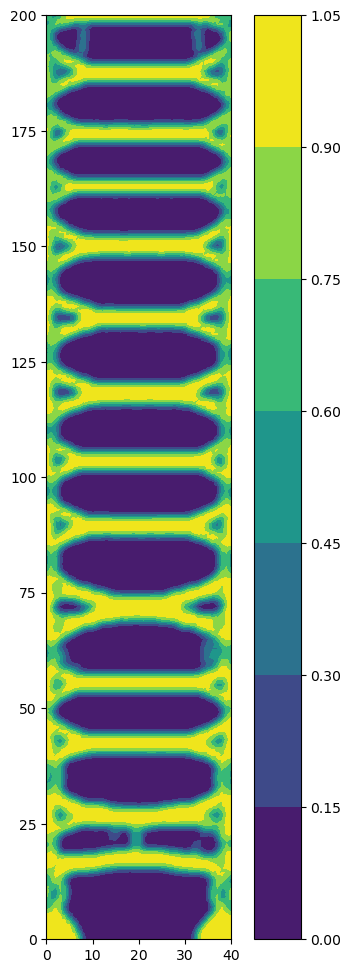

In [265]:
# compute the mass, compliance, and the minimum frequency
final_area = ps.compute_area(mma.x)
final_compliance = ps.compliance(mma.x)
final_lambda = ps.ks_min_eigenvalue(mma.x, k=5)[0]
print("Frequency: ", ps.frequencies(mma.x, k=5)[0])

print("--------RESULTS---------")
if nondim_flag:
    print(f"Final area (nondim): {final_area}")
    print(f"Final area (phys): {scaling.unscale_area(final_area)} m²")
    print(f"Final compliance (nondim): {final_compliance}")
    print(f"Final compliance (phys): {scaling.unscale_stress(final_compliance)} N·m")
    print(f"Final minimum eigenvalue: {final_lambda}")
    final_min_freq = np.sqrt(final_lambda)
    print(f"Final minimum frequency (nondim): {final_min_freq}")
    print(f"Final minimum frequency (phys): {scaling.unscale_frequency(final_min_freq)} Hz")
else:
    print(f"Final area (phys): {final_area} m²")
    print(f"Final compliance (phys): {final_compliance} N·m")
    print(f"Final minimum eigenvalue: {final_lambda}")
    final_min_freq = np.sqrt(final_lambda)
    print(f"Final minimum frequency (phys): {final_min_freq} Hz")

# create a figure ax to pass to fltr.plot
plt.figure(figsize=(6, 12))
ax = plt.gca()
fltr.plot(fltr.apply_filter(mma.x), ax)
plt.show()

In [266]:
# Now adding frequency constraint
f_target = 20.0  # target frequency in Hz (physical)
if nondim_flag:
    f_target_nondim = scaling.scale_frequency(f_target)
    print(f"Target frequency for constraint (nondim): {f_target_nondim}")
    opt = MassFreqConstrainedCompliance(ps, area_fraction * Lx_nondim * Ly_nondim, min_freq=f_target_nondim)
else:
    opt = MassFreqConstrainedCompliance(ps, area_fraction * Lx * Ly, min_freq=f_target)

lb = 1e-3 * np.ones(nnodes)
ub = np.ones(nnodes)
x_init = area_fraction * np.ones(nnodes)

opt.check_gradient(x_init)

mma = MMA(nnodes, 2, x_init, lb, ub, opt.obj_con, opt.obj_con_grad)

total_iter = 600
for i in range(total_iter):
    mma.update()
    print(f"Iteration {i+1}/{total_iter} completed")



Objective: 
Finite-difference:   -1.202933e+08 Answer:  -1.2029361e+08 Relative err:   2.5801266e-06
Constraint 0
Finite-difference:       4033.3942 Answer:       4033.3942 Relative err:  -5.2460448e-09
Constraint 1
Finite-difference:        1022.037 Answer:       1020.7942 Relative err:   -0.0012160396
Iteration 1/600 completed
Iteration 2/600 completed
Iteration 3/600 completed
Iteration 4/600 completed


KeyboardInterrupt: 

Frequency:  [ 7.31661136 25.56360076 39.30439438 52.59733297 81.11053286]
--------RESULTS---------
Final area (phys): 3199.0818262685193 m²
Final compliance (phys): 19350341.146813355 N·m
Final minimum eigenvalue: 53.53280176399667
Final minimum frequency (phys): 7.316611357998775 Hz


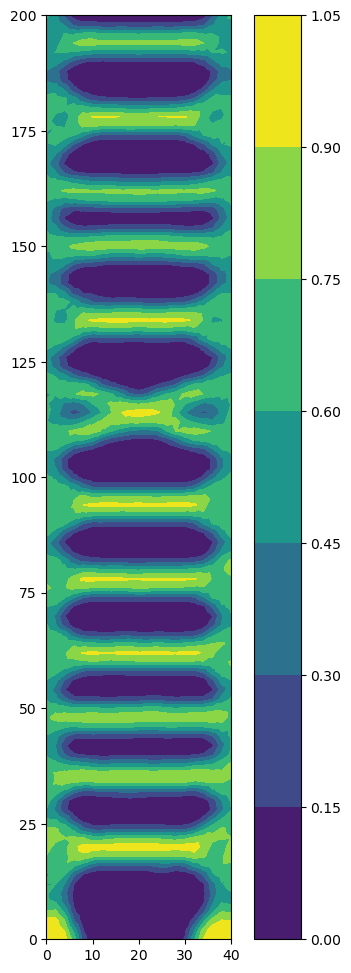

In [259]:
# compute the mass, compliance, and the minimum frequency
final_area = ps.compute_area(mma.x)
final_compliance = ps.compliance(mma.x)
final_lambda = ps.ks_min_eigenvalue(mma.x, k=5)[0]
print("Frequency: ", ps.frequencies(mma.x, k=5)[0])

print("--------RESULTS---------")
if nondim_flag:
    print(f"Final area (nondim): {final_area}")
    print(f"Final area (phys): {scaling.unscale_area(final_area)} m²")
    print(f"Final compliance (nondim): {final_compliance}")
    print(f"Final compliance (phys): {scaling.unscale_stress(final_compliance)} N·m")
    print(f"Final minimum eigenvalue: {final_lambda}")
    final_min_freq = np.sqrt(final_lambda)
    print(f"Final minimum frequency (nondim): {final_min_freq}")
    print(f"Final minimum frequency (phys): {scaling.unscale_frequency(final_min_freq)} Hz")
else:
    print(f"Final area (phys): {final_area} m²")
    print(f"Final compliance (phys): {final_compliance} N·m")
    print(f"Final minimum eigenvalue: {final_lambda}")
    final_min_freq = np.sqrt(final_lambda)
    print(f"Final minimum frequency (phys): {final_min_freq} Hz")
# create a figure ax to pass to fltr.plot
plt.figure(figsize=(6, 12))
ax = plt.gca()
fltr.plot(fltr.apply_filter(mma.x), ax)
plt.show()

### Lecture example 

reduced: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

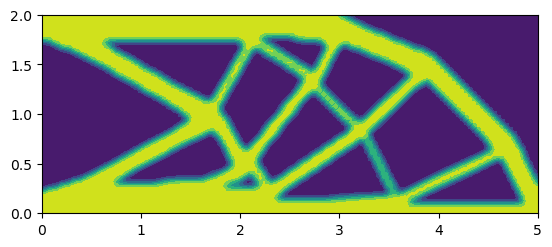

In [ ]:

# Set the dimensions of the design domain
Lx = 5.0
Ly = 2.0
nx = 125
ny = 50

# Set the filter radius
r0 = 2 * (Lx / nx)

# Set the number of elements and nodes
nelems = nx * ny
nnodes = (nx + 1) * (ny + 1)

# Set locations x/y locations along each edge and node numbers
x = np.linspace(0, Lx, nx + 1)
y = np.linspace(0, Ly, ny + 1)
nodes = np.arange(0, (nx + 1) * (ny + 1)).reshape((nx + 1, ny + 1))

# Set the node locations
X = np.zeros((nnodes, 2))
for j in range(ny + 1):
    for i in range(nx + 1):
        X[nodes[i, j], 0] = x[i]
        X[nodes[i, j], 1] = y[j]

# Set the connectivity
conn = np.zeros((nelems, 4), dtype=int)
for j in range(ny):
    for i in range(nx):
        conn[i + j * nx, 0] = nodes[i, j]
        conn[i + j * nx, 1] = nodes[i + 1, j]
        conn[i + j * nx, 2] = nodes[i + 1, j + 1]
        conn[i + j * nx, 3] = nodes[i, j + 1]

# Set boundary conditions for the finite-element problem
bcs = {}
for j in range(ny):
    bcs[nodes[0, j]] = [0, 1]

# Set the load
P = 1.0
forces = {}
forces[nodes[-1, 0]] = [0, -P]

# Create a spatial filter
fltr = NodeFilter(conn, X, r0=r0, ftype="spatial")

# Create the plane stress problem
ps = PlaneStress(conn, X, bcs, forces, fltr=fltr)

# Create the optimization object
area_fraction = 0.4
opt = MassConstrainedCompliance(ps, area_fraction * Lx * Ly)

lb = 1e-3 * np.ones(nnodes)
ub = np.ones(nnodes)
x_init = area_fraction * np.ones(nnodes)

opt.check_gradient(x_init)

mma = MMA(nnodes, 1, x_init, lb, ub, opt.obj_con, opt.obj_con_grad)

total_iter = 50
for i in range(total_iter):
    mma.update()
    print(f"Iteration {i+1}/{total_iter} completed")

fltr.plot(fltr.apply_filter(mma.x))
plt.show()

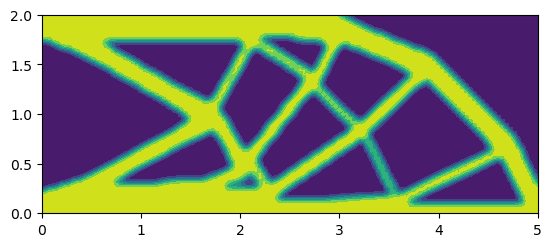

Natural frequencies: [0.30146542 0.63528126 0.78299631 0.88614115 1.05836136]
KS minimum eigenvalue: 0.09088140207152706


In [69]:
fltr.plot(fltr.apply_filter(mma.x))
plt.show()

# compute the model frequency
freqs, modes = ps.frequencies(fltr.apply_filter(mma.x), k=5)
print("Natural frequencies:", freqs)

# also show the ks-value of the minimum eigenvalue
ks_min, _ = ps.ks_min_eigenvalue(fltr.apply_filter(mma.x), k=5)
print("KS minimum eigenvalue:", ks_min)